<a href="https://colab.research.google.com/github/markerenberg/Toxic-Comment-Classification/blob/master/LightGBM_with_SMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Check if GPU is enabled
import tensorflow as tf
tf.test.gpu_device_name()

In [1]:
##
## =======================================================
## Mark Erenberg 
## Toxic Comment Classification Challenge
## =======================================================
##

# Objective: Create a model which predicts a probability of each type of toxicity for each comment.

# import dependencies and files

import os
import time
import pandas as pd
import numpy as np
from scipy import sparse
from scipy.sparse import hstack
import itertools
import matplotlib.pyplot as plt
import re
import tempfile
import warnings
import ast

import lightgbm as lgb

import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag, word_tokenize

import gensim
import gensim.models.keyedvectors as word2vec
from gensim.models.fasttext import FastText
from gensim.models.word2vec import Word2Vec

import spacy
import en_core_web_sm
spacy_nlp = en_core_web_sm.load()
spacy_nlp = spacy.load('en_core_web_sm')
from spacy.lemmatizer import Lemmatizer

from collections import Counter, defaultdict

from sklearn import utils
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, average_precision_score, classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Bidirectional, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.optimizers import Adam
from keras.callbacks import Callback

from imblearn.over_sampling import SMOTE, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

################### Data Loading ###################
#os.chdir('C:\\Users\\marke\\Downloads\\Toxic Classification')
train = pd.read_csv('train.csv').fillna('')
test = pd.read_csv('test.csv').fillna('')

train_text = train[['id','comment_text']].drop_duplicates()
df = pd.concat([train_text,test],axis=0,ignore_index=True)

################### Data Cleaning ####################
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
cv = CountVectorizer(min_df=0., max_df=1.)

# Simple way to get the number of occurence of a regex
def count_regexp_occ(regexp="", text=None):
    return len(re.findall(regexp, text))

# Determine if file words exist:
#print(len(df[df['comment_text'].str.contains('jpg')]))
#print(len(df[df['comment_text'].str.contains('jpeg')]))
#print(len(df[df['comment_text'].str.contains('http')]))
#print(len(df[df['comment_text'].str.contains('pdf')]))
#print(len(df[df['comment_text'].str.contains('html')]))

# Remove non-alphabetic characters and split tokens by spaces/newlines
def clean_document(doc):
    # 1) Convert string to lower
    #doc = bytes(doc.lower(), encoding="utf-8")
    doc = doc.lower()
    # 2) Replace contracion patterns
    cont_patterns = [
    (r'(W|w)on\'t', r'will not'),
    (r'(C|c)an\'t', r'can not'),
    (r'(I|i)\'m', r'i am'),
    (r'(A|a)in\'t', r'is not'),
    (r'(\w+)\'ll', r'\g<1> will'),
    (r'(\w+)n\'t', r'\g<1> not'),
    (r'(\w+)\'ve', r'\g<1> have'),
    (r'(\w+)\'s', r'\g<1> is'),
    (r'(\w+)\'re', r'\g<1> are'),
    (r'(\w+)\'d', r'\g<1> would'),
    ]
    patterns = [(re.compile(regex), repl) for (regex, repl) in cont_patterns]
    for (pattern, repl) in patterns:
        doc = re.sub(pattern, repl, doc)
    # 3) Remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]+', '', doc)
    #doc = doc.encode('utf-8')
    #doc = str(doc,'utf-8').strip()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    #doc = ' '.join(tokens)
    return doc

# Lemmaitze comments:
def lemmatize_comment(comment):
        doc = spacy_nlp(comment)
        return [token.lemma_ for token in doc if token.lemma_ != '-PRON-' ]         


## Clean and lemmatize comments
#df['clean_comments'] = [clean_document(x) for x in df['comment_text']]
#df['clean_comments_list'] = df['clean_comments'].apply(lambda x: x.split())
#df['clean_lemmed'] = [lemmatize_comment(x) for x in df['clean_comments']]
#df['clean_lemmed_str'] = df['clean_lemmed'].apply(lambda x: " ".join(x))
#train['clean_comments'] = [clean_document(x) for x in train['comment_text']]
#train['clean_comments_list'] = train['clean_comments'].apply(lambda x: x.split())
#train['clean_lemmed'] = [lemmatize_comment(x) for x in train['clean_comments']]
#train['clean_lemmed_str'] = train['clean_lemmed'].apply(lambda x: " ".join(x))

## Write to csv for download
#from google.colab import drive
#drive.mount('/content/drive')
#train['clean_comments'].to_csv('train_clean_comments.csv',sep=',',index=False)
#train['clean_lemmed'].to_csv('train_clean_lemmed.csv',sep=',',index=False)

## Read from csv
train_clean_comments = pd.read_csv('train_clean_comments.csv',header=None)
train_clean_lemmed = pd.read_csv('train_clean_lemmed.csv',header=None)

## Transform cleaned/lemmed strings
train['clean_comments'] = train_clean_comments[0].apply(lambda x: str(x))
train['clean_comments_list'] = train['clean_comments'].apply(lambda x: x.split())
train['clean_lemmed'] = train_clean_lemmed[0].apply(lambda x: ast.literal_eval(x))
train['clean_lemmed_str'] = train['clean_lemmed'].apply(lambda x: " ".join(x))

class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
################### Compare with baseline TF-IDF features ###################

# TF-IDF Vectorizer
train_text = train['clean_lemmed_str']

word_vectorizer = TfidfVectorizer(
    min_df = 3,
    max_df = 0.9,
    sublinear_tf=True,
    smooth_idf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 2),
    max_features=20000)
word_vectorizer.fit(train_text)
train_word_features = word_vectorizer.transform(train_text)

char_vectorizer = TfidfVectorizer(
    min_df = 3,
    max_df = 0.9,
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=20000)
char_vectorizer.fit(train_text)
train_char_features = char_vectorizer.transform(train_text)

train_tfidf_features = hstack([train_char_features, train_word_features]).tocsr()
#train_tfidf_features = train_word_features.tocsr()

# Create features about type of text and category of text
def add_features(df):
    # Get length in words and characters
    df["word_count"] = df["comment_text"].apply(lambda x: len(x.split()))
    df["word_len_avg"] = df["comment_text"].apply(lambda x: np.mean([len(x) for x in x.split()]))
    df["word_len_std"] = df["comment_text"].apply(lambda x: np.std([len(x) for x in x.split()]))
    df["char_count"] = df["comment_text"].apply(lambda x: len(x))
    # Create count variables to see if any are useful
    df["upper_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[A-Z]", x)) /df['char_count']*100
    df["number_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[0-9]", x)) / df["char_count"] *100
    df["excl_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"!", x)) / df["char_count"] *100
    df["quest_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\?", x)) / df["char_count"] *100
    df["equals_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"=", x)) / df["char_count"] *100
    df["punct_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[.!\?=+#*|~-]", x)) / df["char_count"] *100
    df["you_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\W[Yy]ou\W", x)) / df["word_count"] *100
    df["nb_fuck"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[Ff][uU][cC][Kk]", x))
    df["nb_suck"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[Ss]\S{2}[Kk]", x))
    df["nb_dick"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[dD]ick", x))
    df["nb_penis"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[pP][eE][nN][iI][sS]", x))
    df["nb_pussy"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[pP][uU][sS][sS][yY]", x))
    df["nb_cock"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[cC]ock", x))
    df["8==D"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"8=+D", x))
    df["nb_gay"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[gG][aA][yY]", x))
    df["nb_bitch"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[bB][iI][tT][cC][hH]", x))
    df["nb_cunt"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[cC][uU][nN][tT]", x))
    df["nb_shut_up"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[sS][hH][uU][tT]\s[uU][pP]", x))
    df["nb_mother"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\Wmother\W", x))
    df["nb_ng"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\Wnigger\W", x))
    df["nb_ng_2"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\Wnigga\W", x))

def pos_tagging(df):
    df["comment_raw"] = df["comment_text"].apply(lambda x: re.sub(r'[\n\r\t\r\n]',r' ',x,re.I|re.U))
    df["POS"] = df["comment_raw"].apply(lambda x: [token.pos_ for token in spacy_nlp(x)])
    
def pos_features(df):
    # Get number of proper nouns
    df["PROPN"] = df["POS"].apply(lambda x: len([pos for pos in x if pos == 'PROPN']))
    df["ADJ"] = df["POS"].apply(lambda x: len([pos for pos in x if pos == 'ADJ']))
    df["INTJ"] = df["POS"].apply(lambda x: len([pos for pos in x if pos == 'INTJ']))
    df["SYM"] = df["POS"].apply(lambda x: len([pos for pos in x if pos == 'SYM']))

    
#add_features(train)
#pos_tagging(df)
#pos_features(df)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:520: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'stop_words' will not be used"


In [0]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from scipy import sparse
class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, tol=1e-4, dual=False, n_jobs=1, multi_class='auto'):
        self.C = C
        self.tol=tol
        self.dual = dual
        self.n_jobs = n_jobs
        self.multi_class = multi_class
        self.class_weight='balanced'

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        #y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, tol=self.tol, dual=self.dual, n_jobs=self.n_jobs, class_weight='balanced').fit(x_nb, y)
        return self

# Set LGBM parameters
params = {
    "objective": "binary",
    'metric': {'auc'},
    "boosting_type": "gbdt",
    "verbosity": -1,
    "num_threads": -1,
    "bagging_fraction": 0.8,
    "feature_fraction": 0.8,
    "learning_rate": 0.1,
    "num_leaves": 31,
    "verbose": -1
    #"min_split_gain": .1,
    #"reg_alpha": .1
}

In [0]:
## See what class imbalance is for response classes
for clss in class_names:
    true = [x for x in train[clss] if x == 1]
    print(clss + ": " + str(round(len(true)/len(train[clss])*100,2))+ "%")


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

SMOTE ratio:  0.05  | mean AUC:  0.8919


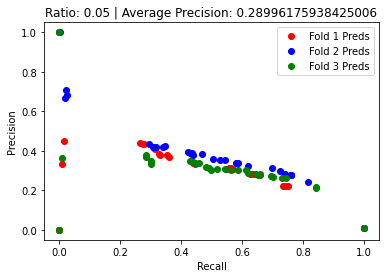

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

SMOTE ratio:  0.1  | mean AUC:  0.8968


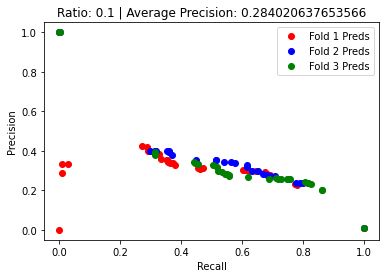

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
##### Investigating class imbalance + improving recall #####
resp = 'severe_toxic'
training_labels = train[resp]
train_features = train_tfidf_features
seed = 1234
splits = 3
folds = StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed)

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.pipeline import Pipeline


## Over_sampling and under_sampling
over_ratios = [0.05,0.1,0.2]



for ratio in over_ratios:
  # Define new re-sampled data
  class_pred = np.zeros(train_features.shape[0])
  # Use 5-fold cross-validation to evaluate performance at given over-sampling ratio.
  auc,precision,recall,thresholds = [],[],[],[]
  for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_features, training_labels)):
    # Define pipeline to oversample, undersample, and then cross-validate using NB-SVM
    over = SVMSMOTE(sampling_strategy=ratio,k_neighbors=5)
    under = TomekLinks(sampling_strategy='majority')
    #steps = [('over', over), ('under', under), ('model', model)]
    #pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    X_re, y_re = over.fit_resample(train_features[trn_idx],training_labels[trn_idx])
    X_re, y_re = under.fit_resample(X_re,y_re)    
    trn_lgbset = lgb.Dataset(X_re, free_raw_data=False)
    trn_lgbset.set_label(y_re)
    lgb_rounds = 500
    #pipeline.fit(train_features[trn_idx], training_labels[trn_idx])
    #y_hat = pipeline.predict(train_features[val_idx])
    #print(classification_report(training_labels[val_idx], y_hat))

    #X_re, y_re = smt.fit_sample(train_features[trn_idx], training_labels[trn_idx])
    #print("Class distribution with ratio {}: ".format(str(ratio)),sorted(Counter(y_re).items()))
    #model = NbSvmClassifier(C=4, tol=1e-4, dual=False, n_jobs=-1,multi_class='auto').fit(X_re, y_re)
    model = lgb.train(params=params,
                      train_set=trn_lgbset, 
                      num_boost_round=lgb_rounds,
                      valid_sets=[lgb.Dataset(train_features[val_idx], free_raw_data=False)],
                      early_stopping_rounds=50,
                      verbose_eval=0)
    #class_pred[val_idx] = model.predict_proba(train_features[val_idx])[:,1]
    class_pred[val_idx] = model.predict(train_features[val_idx], num_iteration=model.best_iteration)
    #print(classification_report(training_labels[val_idx], class_pred[val_idx]))
    auc.append(roc_auc_score(training_labels[val_idx], class_pred[val_idx],average='weighted'))
    prec, recal, thresh = precision_recall_curve(training_labels[val_idx], class_pred[val_idx])
    precision.append(prec)
    recall.append(recal)
    thresholds.append(thresh)
  # Print out mean AUC score
  print("SMOTE ratio: ",str(ratio),' | mean AUC: ',str(round(np.mean(auc),4)))
  # Plot precision-recall curve
  plt.figure()
  plt.plot(recall[0], precision[0], 'ro', linewidth=2,label='Fold 1 Preds')
  plt.plot(recall[1], precision[1], 'bo', linewidth=2,label='Fold 2 Preds')
  plt.plot(recall[2], precision[2], 'go', linewidth=2,label='Fold 3 Preds')
  #plt.plot(recall[3], precision[3], 'yo', linewidth=2,label='Fold 4 Preds')
  #plt.plot(recall[4], precision[4], 'mo', linewidth=2,label='Fold 5 Preds')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Ratio: '+str(ratio)+' | Average Precision: '+str(average_precision_score(training_labels,class_pred,average='weighted')))
  plt.legend()
  plt.show()


In [0]:
resp = 'severe_toxic'
training_labels = train[resp]
train_features = train_tfidf_features
seed = 1234
splits = 5
folds = StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed)

ratio = 0.1

class_pred = np.zeros(train_features.shape[0])
# Use 5-fold cross-validation to evaluate performance at given over-sampling ratio.
auc,precision,recall,thresholds = [],[],[],[]
(trn_idx, val_idx) = list(folds.split(train_features, training_labels))[0]
# Define pipeline to oversample, undersample, and then cross-validate using NB-SVM
over = SVMSMOTE(sampling_strategy=ratio,k_neighbors=5)
under = TomekLinks(sampling_strategy='majority')
#steps = [('over', over), ('under', under), ('model', model)]
#pipeline = Pipeline(steps=steps)
# evaluate pipeline
X_re, y_re = over.fit_resample(train_features[trn_idx],training_labels[trn_idx])
X_re, y_re = under.fit_resample(X_re,y_re)
#pipeline.fit(train_features[trn_idx], training_labels[trn_idx])
#y_hat = pipeline.predict(train_features[val_idx])
#print(classification_report(training_labels[val_idx], y_hat))

  

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:

# Check that X and y have correct shape
#y = y.values
x, y = check_X_y(x, y, accept_sparse=True)

def pr(x, y_i, y):
  p = x[y==y_i].sum(0)
  return (p+1) / ((y==y_i).sum()+1)

r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
x_nb = x.multiply(self._r)
self._clf = LogisticRegression(C=self.C, tol=self.tol, dual=self.dual, n_jobs=self.n_jobs, class_weight='balanced').fit(x_nb, y)
return self

In [0]:
#X_re, y_re = smt.fit_sample(train_features[trn_idx], training_labels[trn_idx])
#print("Class distribution with ratio {}: ".format(str(ratio)),sorted(Counter(y_re).items()))
model = NbSvmClassifier(C=4, tol=1e-4, dual=False, n_jobs=-1,multi_class='auto').fit(X_re, y_re)
class_pred[val_idx] = model.predict_proba(train_features[val_idx])[:,1]
print(classification_report(training_labels[val_idx], class_pred[val_idx]))
auc.append(roc_auc_score(training_labels[val_idx], class_pred[val_idx],average='weighted'))
prec, recal, thresh = precision_recall_curve(training_labels[val_idx], class_pred[val_idx])
precision.append(prec)
recall.append(recal)
thresholds.append(thresh)

In [0]:
# Fit model using 5-fold CV, display PR curve
resp = 'severe_toxic'
train_features = train_tfidf_features

training_labels = train[resp]
class_pred = np.zeros(train_features.shape[0])
auc,precision,recall,thresholds = [],[],[],[]

# Make predictions for each fold in split, calculate evaluation metrics
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_features, training_labels)):
  # Train NB-SVM
  model = NbSvmClassifier(C=4, tol=1e-4, dual=False, n_jobs=-1,multi_class='auto').fit(train_features[trn_idx], training_labels[trn_idx])
  class_pred[val_idx] = model.predict_proba(train_features[val_idx])[:,1]
  auc.append(roc_auc_score(training_labels[val_idx], class_pred[val_idx],average='weighted'))
  prec, recal, thresh = precision_recall_curve(training_labels[val_idx], class_pred[val_idx])
  precision.append(prec)
  recall.append(recal)
  thresholds.append(thresh)

# Print out mean AUC score
print("fit: ",resp,' | mean AUC: ',str(round(np.mean(auc),4)))
print("Thresholds: "+str(thresholds[4]))
print("Precision: "+str(precision[4]))
# Plot precision-recall curve
plt.figure()
plt.plot(recall[0], precision[0], 'ro', linewidth=2,label='Fold 1 Preds')
plt.plot(recall[1], precision[1], 'bo', linewidth=2,label='Fold 2 Preds')
plt.plot(recall[2], precision[2], 'go', linewidth=2,label='Fold 3 Preds')
plt.plot(recall[3], precision[3], 'yo', linewidth=2,label='Fold 4 Preds')
plt.plot(recall[4], precision[4], 'mo', linewidth=2,label='Fold 5 Preds')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Class: '+resp+' | Average Precision: '+str(average_precision_score(training_labels,class_pred,average='weighted')))
plt.legend()
plt.show()

In [0]:
##### Fit NBSVM Model #####
warnings.filterwarnings("ignore")

train_features = train_tfidf_features

#class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
class_names = ['severe_toxic','threat','identity_hate']
seed = 1234
splits = 5
folds = StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed)

for i, j in enumerate(class_names):
    training_labels = train[j]
    class_pred = np.zeros(len(train))
    auc,precision,recall,thresholds = [],[],[],[]

    # Make predictions for each fold in split, calculate evaluation metrics
    for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_features, training_labels)):
      # Train NB-SVM
      model = NbSvmClassifier(C=4, tol=1e-4, dual=False, n_jobs=-1,multi_class='auto')
      model.fit(train_features[trn_idx], training_labels[trn_idx])
      class_pred[val_idx] = model.predict_proba(train_features[val_idx])[:,1]
      auc.append(roc_auc_score(training_labels[val_idx], class_pred[val_idx],average='weighted'))
      prec, recal, thresh = precision_recall_curve(training_labels[val_idx], class_pred[val_idx])
      precision.append(prec)
      recall.append(recal)
      thresholds.append(thresh)

    # Print out mean AUC score
    print("fit: ",j,' | mean AUC: ',str(round(np.mean(auc),4)))
    print("Thresholds: "+str(thresholds[4]))
    print("Precision: "+str(precision[4]))
    # Plot precision-recall curve
    plt.figure()
    plt.plot(recall[0], precision[0], 'ro', linewidth=2,label='Fold 1 Preds')
    plt.plot(recall[1], precision[1], 'bo', linewidth=2,label='Fold 2 Preds')
    plt.plot(recall[2], precision[2], 'go', linewidth=2,label='Fold 3 Preds')
    plt.plot(recall[3], precision[3], 'yo', linewidth=2,label='Fold 4 Preds')
    plt.plot(recall[4], precision[4], 'mo', linewidth=2,label='Fold 5 Preds')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Class: '+j+' | Average Precision: '+str(average_precision_score(training_labels,class_pred,average='weighted')))
    plt.legend()
    plt.show()
    



In [0]:
##### Bayesian Hyperparameter Tuning for Severe Toxic Class #####

#warnings.filterwarnings("ignore")

train_features = train_tfidf_features

class_names_2 = ['severe_toxic', 'threat', 'identity_hate']
seed = 1234
splits = 5
folds = StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed)

j = 'threat'
training_labels = train[j]
class_pred = np.zeros(train_features.shape[0])
auc,precision,recall,thresholds = [],[],[],[]

### Define functions for Bayesian Hyperparameter Optimization (SMBO using TPE)
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, space_eval
from sklearn.metrics import r2_score, roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, make_scorer

# 1) Define objective 

def objective(params):
    time1 = time.time()
    params = {
        'C': params['C'],
        'tol': params['tol'],
    }

    print("\n############## New Run ################")
    print(f"params = {params}")
    seed = 1234
    splits = 5
    folds = StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed)
    score_mean = 0
    class_pred = np.zeros(train_features.shape[0])

    for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_features, training_labels)):
      clf = NbSvmClassifier(C=params['C'], tol=params['tol'], dual=False,n_jobs=-1,multi_class='auto')
      clf.fit(train_features[trn_idx], training_labels[trn_idx])
      class_pred[val_idx] = clf.predict_proba(train_features[val_idx])[:,1]
      score = average_precision_score(training_labels[val_idx],class_pred[val_idx],average='weighted')
      score_mean += score
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    #gc.collect()
    print(f'Average Precision Score: {score_mean/splits}')
    return -(score_mean / splits)


# 2) Define search space

space = {
    'C': hp.lognormal('C', 0,1),
    'tol': hp.choice('tol',[1e-7,1e-6,1e-5,1e-4,1e-3,1e-2])
}    

# 3) Specify Optimization algorithm
tpe_algo = tpe.suggest

# 4) Instantiate Trials object to track results
tpe_trials = Trials()

# Set hyperopt parameters
best = fmin(fn=objective,
            space=space,
            algo=tpe_algo,
            trials = tpe_trials,
            max_evals=1000)
# Print best parameters
best_params = space_eval(space, best)
print("BEST PARAMS: ", best_params)

# Make predictions for each fold in split, calculate evaluation metrics
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_features, training_labels)):
  # Train NB-SVM
  model = NbSvmClassifier(C=best_params['C'], tol=best_params['tol'], dual=False, n_jobs=-1,multi_class='auto')
  model.fit(train_features[trn_idx], training_labels[trn_idx])
  class_pred[val_idx] = model.predict_proba(train_features[val_idx])[:,1]
  auc.append(roc_auc_score(training_labels[val_idx], class_pred[val_idx],average='weighted'))
  prec, recal, thresh = precision_recall_curve(training_labels[val_idx], class_pred[val_idx])
  precision.append(prec)
  recall.append(recal)
  thresholds.append(thresh)

# Print out mean AUC score
print("fit: ",j,' | mean AUC: ',str(round(np.mean(auc),4)))
# Plot precision-recall curve
plt.figure()
plt.plot(recall[0], precision[0], 'ro', linewidth=2,label='Fold 1 Preds')
plt.plot(recall[1], precision[1], 'bo', linewidth=2,label='Fold 2 Preds')
plt.plot(recall[2], precision[2], 'go', linewidth=2,label='Fold 3 Preds')
plt.plot(recall[3], precision[3], 'yo', linewidth=2,label='Fold 4 Preds')
plt.plot(recall[4], precision[4], 'mo', linewidth=2,label='Fold 5 Preds')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Class: '+j+' | Average Precision: '+str(average_precision_score(training_labels,class_pred,average='weighted')))
plt.legend()
plt.show()
    